In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from hmmlearn import hmm
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Bước 1: Tải và tiền xử lý dữ liệu
file_path = 'D:\Study\Chuoi thoi gian\Kiemtra\data-kiem-tra-2.csv' 

data = pd.read_csv(file_path, delimiter=';')

# Chuyển đổi cột 'date' sang định dạng datetime
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')

# Kiểm tra giá trị thiếu
missing_values = data.isnull().sum()
print(f"Missing values:\n{missing_values}")

#Xóa dấu chấm trong cột 'truong_4'
data['truong_4'] = data['truong_4'].str.replace('.', '')

# Chuẩn hóa các cột số liệu
scaler = StandardScaler()
data[['truong_1', 'truong_2', 'truong_3', 'truong_4', 'truong_5']] = scaler.fit_transform(
    data[['truong_1', 'truong_2', 'truong_3', 'truong_4', 'truong_5']]
)


# Bước 2: Kiểm tra trùng lặp ngày
duplicated_dates = data['date'].duplicated().sum()
print(f"Number of duplicated dates: {duplicated_dates}")

# Tính trung bình các giá trị cho mỗi ngày trùng lặp
data_aggregated = data.groupby('date').mean().reset_index()

# Kiểm tra lại dữ liệu sau khi loại bỏ các trùng lặp và tính trung bình
print(f"Data after aggregating duplicates:\n{data_aggregated.head()}")

# Thiết lập cột 'date' làm chỉ số
data_aggregated.set_index('date', inplace=True)

# Kiểm tra tính liên tục của dữ liệu
all_dates = pd.date_range(start=data_aggregated.index.min(), end=data_aggregated.index.max(), freq='D')
missing_dates = all_dates.difference(data_aggregated.index)

print(f"Missing dates:\n{missing_dates}")

# Điền giá trị bị thiếu
data_filled = data_aggregated.reindex(all_dates).fillna(method='ffill')

# Kiểm tra lại dữ liệu sau khi điền giá trị bị thiếu
print("Data after filling missing values:")
print(data_filled.head(10))

# Chuẩn hóa lại các cột số liệu sau khi điền giá trị bị thiếu
data_filled[['truong_1', 'truong_2', 'truong_3', 'truong_4', 'truong_5']] = scaler.fit_transform(
    data_filled[['truong_1', 'truong_2', 'truong_3', 'truong_4', 'truong_5']]
)

Missing values:
date        0
truong_1    0
truong_2    0
truong_3    0
truong_4    0
truong_5    0
dtype: int64
Number of duplicated dates: 549824
Data after aggregating duplicates:
        date  truong_1  truong_2  truong_3  truong_4  truong_5
0 2013-05-01 -1.785036 -0.224808 -0.007645 -0.039978 -0.074506
1 2013-05-02 -1.785036 -0.190042  0.037138 -0.009852 -0.070146
2 2013-05-03 -1.785036 -0.187567 -0.025286 -0.039978 -0.081470
3 2013-05-04 -1.785036 -0.126539 -0.022079 -0.039975 -0.086247
4 2013-05-05 -1.785036 -0.106864  0.107089 -0.014754 -0.092037
Missing dates:
DatetimeIndex([], dtype='datetime64[ns]', freq='D')
Data after filling missing values:
            truong_1  truong_2  truong_3  truong_4  truong_5
2013-05-01 -1.785036 -0.224808 -0.007645 -0.039978 -0.074506
2013-05-02 -1.785036 -0.190042  0.037138 -0.009852 -0.070146
2013-05-03 -1.785036 -0.187567 -0.025286 -0.039978 -0.081470
2013-05-04 -1.785036 -0.126539 -0.022079 -0.039975 -0.086247
2013-05-05 -1.785036 -0.106864  

C:\Users\admin\AppData\Local\Temp\ipykernel_19136\2085847159.py:50: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_filled = data_aggregated.reindex(all_dates).fillna(method='ffill')


In [10]:
# Tách dữ liệu thành phần train và test
train = data_filled.iloc[:-30]
test = data_filled.iloc[-30:]

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


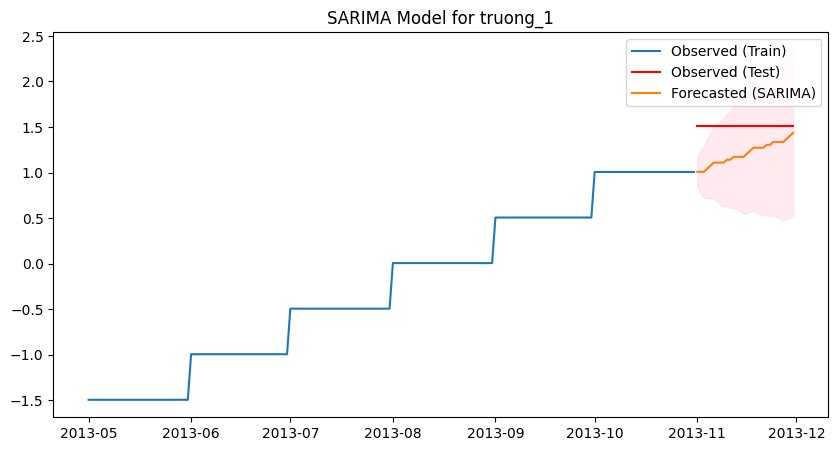

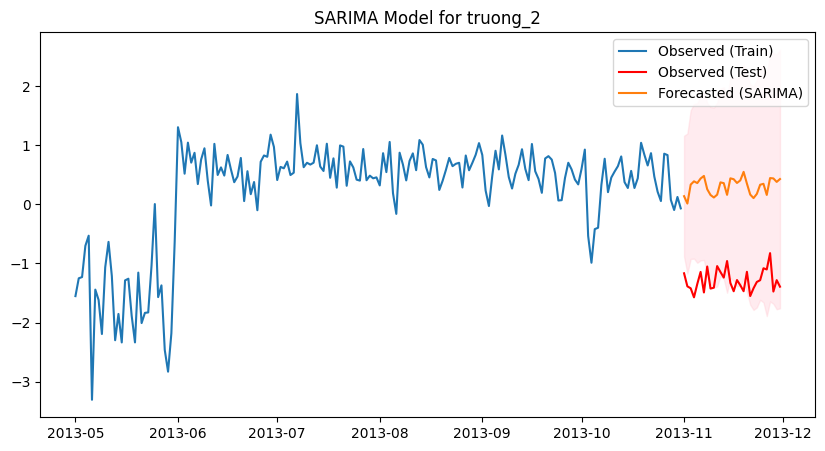

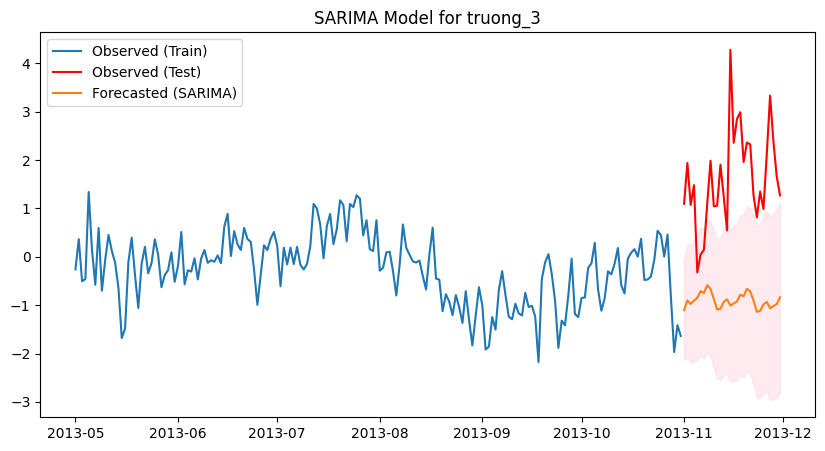

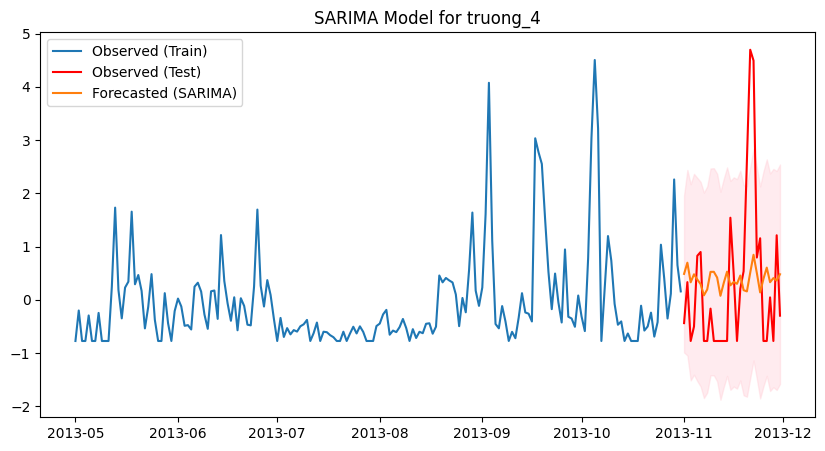

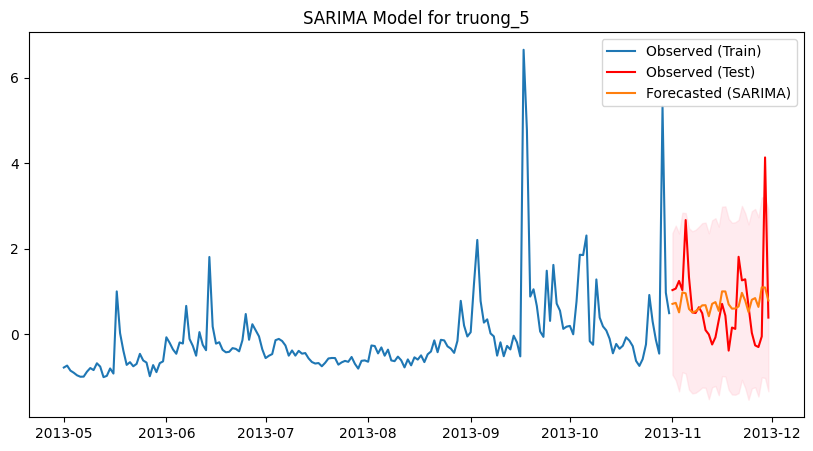

In [13]:
# Dự báo cho mỗi cột với mô hình SARIMA 
columns = ['truong_1', 'truong_2', 'truong_3', 'truong_4', 'truong_5']
for column in columns:
    # Mô hình SARIMA
    sarima_model = sm.tsa.statespace.SARIMAX(train[column], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_result = sarima_model.fit()

    # Dự báo với mô hình SARIMA
    sarima_forecast = sarima_result.get_forecast(steps=30)
    sarima_predicted_mean = sarima_forecast.predicted_mean
    sarima_conf_int = sarima_forecast.conf_int()

    # Vẽ đồ thị kết quả dự báo SARIMA
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train[column], label='Observed (Train)')
    plt.plot(test.index, test[column], label='Observed (Test)', color='red')
    plt.plot(test.index, sarima_predicted_mean, label='Forecasted (SARIMA)')
    plt.fill_between(test.index, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='pink', alpha=0.3)
    plt.legend()
    plt.title(f'SARIMA Model for {column}')
    plt.show()

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


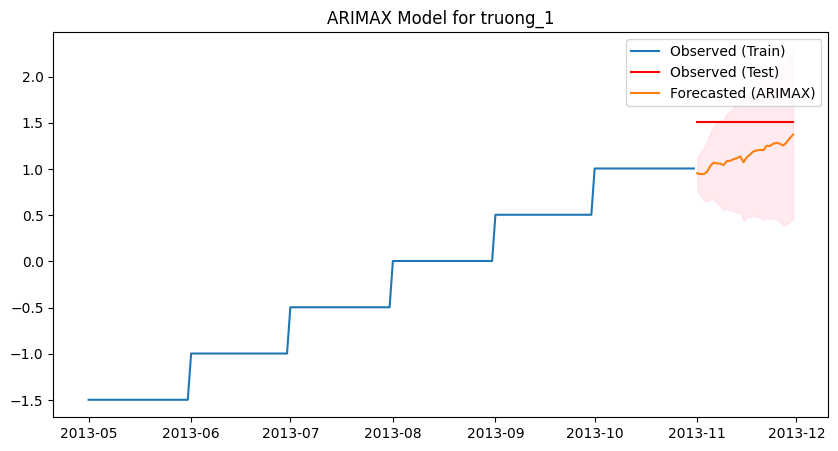

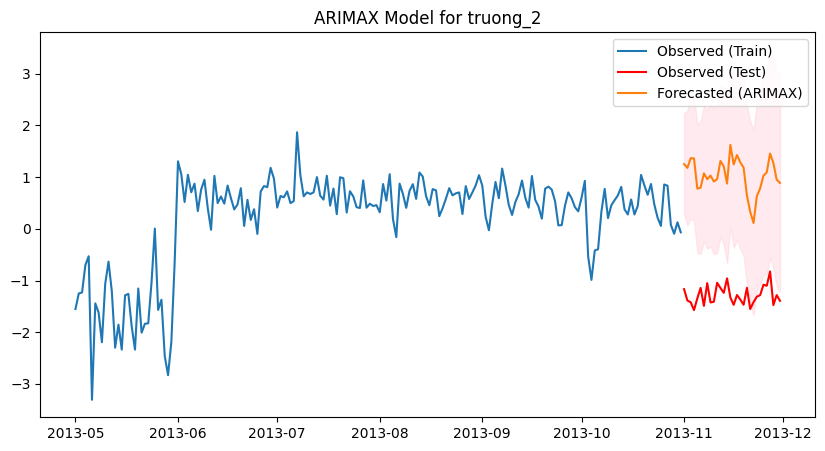

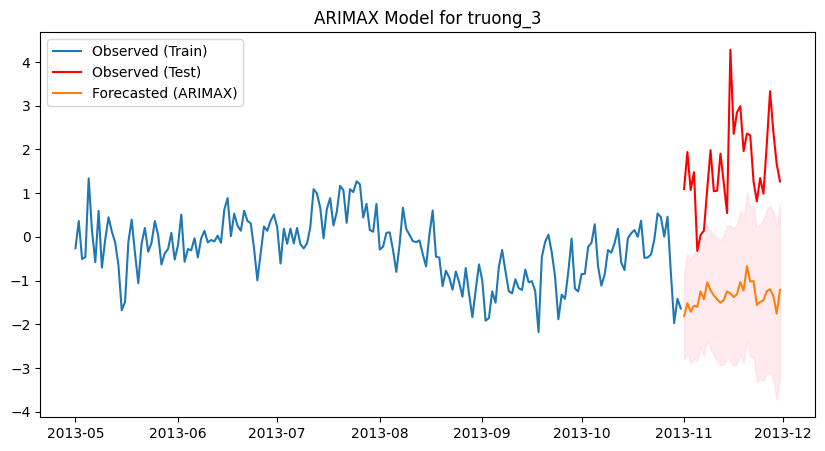

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


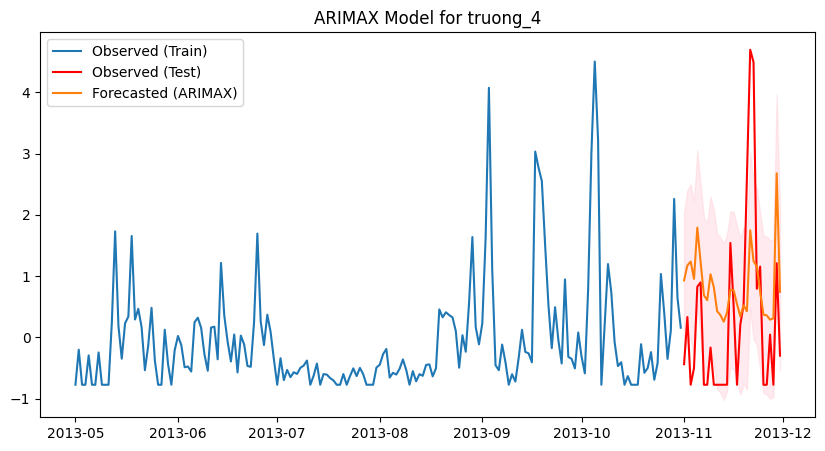

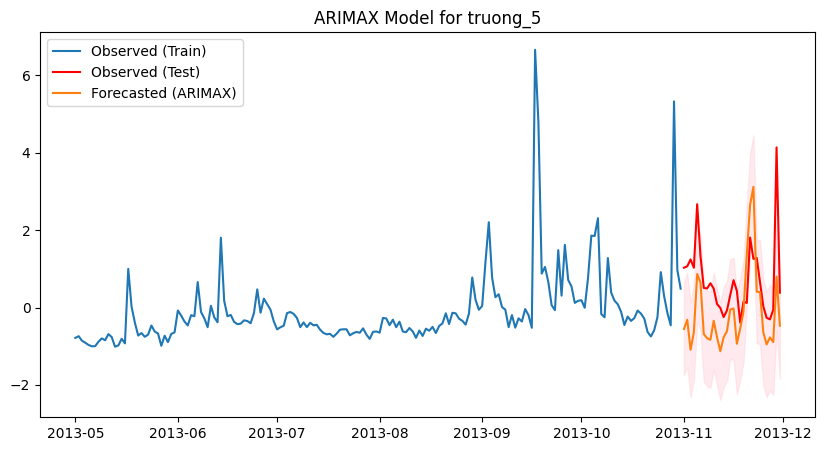

In [14]:
# Dự báo cho mỗi cột với mô hình ARIMAX
columns = ['truong_1', 'truong_2', 'truong_3', 'truong_4', 'truong_5']
arimax_forecasts = {}

for column in columns:
    # Mô hình ARIMAX
    exog_train = train.drop(columns=[column])
    exog_test = test.drop(columns=[column])

    arimax_model = sm.tsa.statespace.SARIMAX(train[column], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=exog_train)
    arimax_result = arimax_model.fit()

    # Dự báo với mô hình ARIMAX
    arimax_forecast = arimax_result.get_forecast(steps=30, exog=exog_test)
    arimax_predicted_mean = arimax_forecast.predicted_mean
    arimax_conf_int = arimax_forecast.conf_int()

    arimax_forecasts[column] = arimax_predicted_mean

    # Vẽ đồ thị kết quả dự báo ARIMAX
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train[column], label='Observed (Train)')
    plt.plot(test.index, test[column], label='Observed (Test)', color='red')
    plt.plot(test.index, arimax_predicted_mean, label='Forecasted (ARIMAX)')
    plt.fill_between(test.index, arimax_conf_int.iloc[:, 0], arimax_conf_int.iloc[:, 1], color='pink', alpha=0.3)
    plt.legend()
    plt.title(f'ARIMAX Model for {column}')
    plt.show()
